<h1><center><b>Deep Learning for Machine Perception</b></center></h1>


<font color='red'>

Netanel Tamir, 204900062  
</font>

<font color='black'>

Most of the code was taken from my solution to EX4

The segmentation was done by the tutorial here : https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/

The TV Loss function was taken from here : https://github.com/jxgu1016/Total_Variation_Loss.pytorch

The rest of the code was written by myself.
</font>

____________

In [ ]:
# Imports

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
# Paths for images

content_image_path = "./mancar.jpg"
style1_image_path = "./style12.jpg"
style2_image_path = "./style11.jpg"
style3_image_path = "./style13.jpg"

In [ ]:
# Image Path To Numpy Function
def image_path_to_numpy(image_path):
  return Image.open(image_path).convert('RGB') 

In [ ]:
# Create numpy arrays from paths

content_numpy = image_path_to_numpy(content_image_path)
style1_numpy = image_path_to_numpy(style1_image_path)
style2_numpy = image_path_to_numpy(style2_image_path)
style3_numpy = image_path_to_numpy(style3_image_path)

Text(0.5, 1.0, 'Style3 Image')

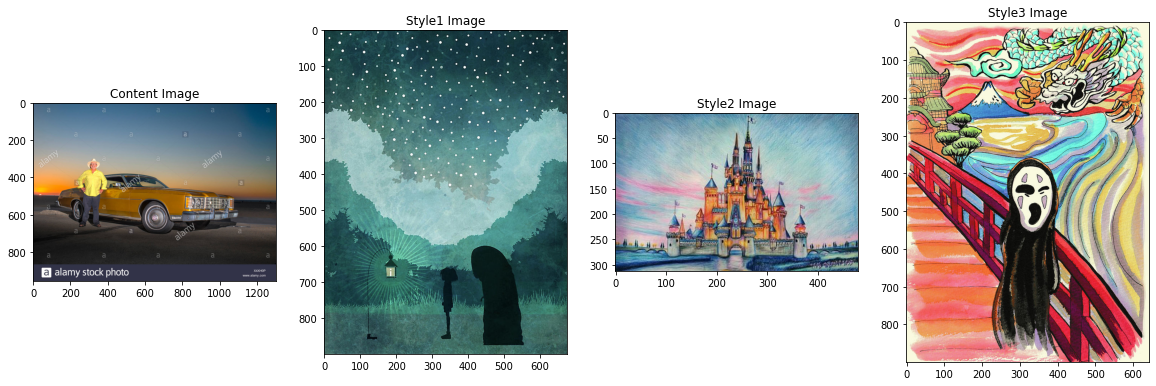

In [ ]:
# Display the images
fig, (ax1, ax2 ,ax3,ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(content_numpy)
ax1.set_title("Content Image")
ax2.imshow(style1_numpy)
ax2.set_title("Style1 Image")
ax3.imshow(style2_numpy)
ax3.set_title("Style2 Image")
ax4.imshow(style3_numpy)
ax4.set_title("Style3 Image")

In [ ]:
# Convert image to tensor

def image_to_tensor(image_numpy, max_size=400, shape=None):
  
  # crop image if image is too big
  size = max_size
  size = (size, int(1.5*size))
  # if shape is given use it
  if shape is not None:
    size = shape
  
  # resize and normalize the image
  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image_numpy)[:3, :, :].unsqueeze(0)
  
  return image

In [ ]:
#Convert images to tensors and print their shapes

content_tensor = image_to_tensor(content_numpy)
print("Content Shape:", content_tensor.shape)

style1_tensor = image_to_tensor(style1_numpy)
print("Style1 Shape:", style1_tensor.shape)

style2_tensor = image_to_tensor(style2_numpy)
print("Style2 Shape:", style2_tensor.shape)

style3_tensor = image_to_tensor(style3_numpy)
print("Style3 Shape:", style3_tensor.shape)

Content Shape: torch.Size([1, 3, 400, 600])
Style1 Shape: torch.Size([1, 3, 400, 600])
Style2 Shape: torch.Size([1, 3, 400, 600])
Style3 Shape: torch.Size([1, 3, 400, 600])


In [ ]:
#Convert tensor to numpy array function

def tensor_to_numpy(image_tensor):
  image = image_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

In [ ]:
# Get resnet model for segmentation

fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()
out = fcn(content_tensor)['out']
print (out.shape)

torch.Size([1, 21, 400, 600])


In [ ]:
# Function for decoding segmentation map

def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [ ]:
# Create segmentation map

om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)

(400, 600)


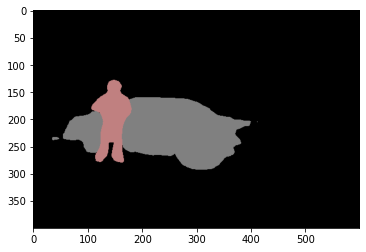

In [ ]:
# Plot segmentation map

rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()

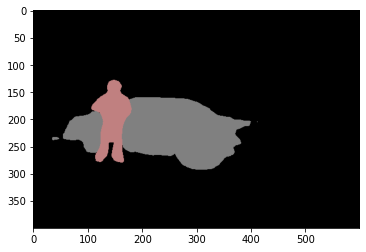

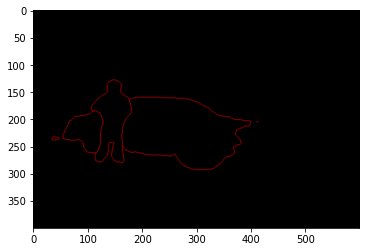

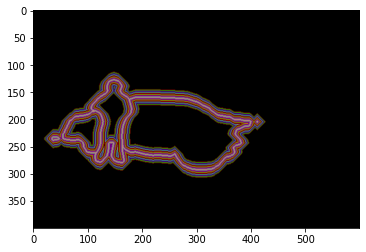

In [ ]:
# Create a segmentation map with only background,dog,cat

fixed_om=np.copy(om)
for i in range(400):
  for j in range(600):
    if(fixed_om[i][j]!=0 and fixed_om[i][j]!=7 and fixed_om[i][j]!=15):
      fixed_om[i][j]=0
rgb = decode_segmap(fixed_om)
plt.imshow(rgb); plt.show()


# Create map showing borders between segments

blur_map=np.zeros((400,600))

for i in range(400):
  for j in range(600):
    color=fixed_om[i][j]
    if (i-1>=0 and fixed_om[i-1][j] != color):
      blur_map[i][j]=1
    elif (i+1<=399 and fixed_om[i+1][j] != color):
      blur_map[i][j]=1
    elif (j-1>=0 and fixed_om[i][j-1] != color):
      blur_map[i][j]=1
    elif (j+1<=599 and fixed_om[i][j+1] != color):
      blur_map[i][j]=1
    else:
      blur_map[i][j]=0

rgb = decode_segmap(blur_map)
plt.imshow(rgb); plt.show()

# Function to increase blur size

def increaseBlur(blur_map,size):
  for k in range(size):
    new_blur_map=np.zeros((400,600))
    for i in range(400):
      for j in range(600):
        color=blur_map[i][j]
        if (color >= 1):
          new_blur_map[i][j]=color
          if (i-1>=0 and new_blur_map[i-1][j]==0):
            new_blur_map[i-1][j]=color+1
          if (i+1<=399 and new_blur_map[i+1][j]==0):
            new_blur_map[i+1][j]=color+1
          if (j-1>=0 and new_blur_map[i][j-1]==0):
            new_blur_map[i][j-1]=color+1
          if (j+1<=599 and new_blur_map[i][j+1]==0):
            new_blur_map[i][j+1]=color+1
    blur_map = np.copy(new_blur_map)
  return blur_map

# Function to flip blur values

def flipBlur(blur_map,size):
  new_blur_map=np.copy(blur_map)
  for i in range(400):
      for j in range(600):
        color=blur_map[i][j]
        if (color>0):
          new_blur_map[i][j] = size+1-color
  return new_blur_map

# Create increased blur map and plot it  
blur_map = flipBlur(increaseBlur(blur_map,15),15)
rgb = decode_segmap(blur_map)
plt.imshow(rgb); plt.show()


In [ ]:
# Get pretrained vgg19 model

vgg = models.vgg19(pretrained=True)

In [ ]:
# Print the modules of the vgg model

print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Function for freezing the network

def freeze_network(net):
  '''
  The function freezes all layers of a pytorch network (net).
  '''
  for param in net.parameters():
    param.requires_grad = False

In [ ]:
# Freeze all VGG parameters
freeze_network(vgg)

In [ ]:
# Function for replacing max pooling with average pooling
def replace_max_pooling(net):
  '''
  The function replaces max pooling layers with average pooling layers with 
  the following properties: #filters=2, stride=2, padding=0.
  '''
  for i in range(len(net.features)):
    if net.features[i].__class__.__name__ is 'MaxPool2d' :
      net.features[i]=torch.nn.AvgPool2d(2, stride=2, padding=0)
  return

In [ ]:
# Replace max pooling with avg pooling
replace_max_pooling(vgg)

In [ ]:
# Print the modules of the vgg model

print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace=True)
    (18): AvgPool

In [ ]:
# Move the model to the GPU
vgg = vgg.to("cuda").eval()

# Move images to gpu
content_tensor = content_tensor.to("cuda")
style1_tensor = style1_tensor.to("cuda")
style2_tensor = style2_tensor.to("cuda")
style3_tensor = style3_tensor.to("cuda")



In [ ]:
# Function that gets the features from from image tensor

def get_features(net, image_tensor):
    ''' 
    The function runs a forward pass given an image and extracts the features for 
    several conv layers. It returns a dictionary where the keys are the
    layers name and the values are the features.
    '''
    layers_idx = ['0','5','10','19','21','28']
    features={}
    for i in layers_idx:
      features[i]=net.features[:(int(i)+2)](image_tensor)
    return features

In [ ]:
# Function for calculating content loss

def calculate_content_loss(target_features, content_features, layer_id='21'):
  content_loss = F.mse_loss(target_features[layer_id],content_features[layer_id])
  return content_loss

In [ ]:
# Function for creating gram matrix from tensor
def calculate_gram_matrix(tensor):
    ''' 
    The function calculates the Gram Matrix of a given tensor with shape (batch_size, depth, height, width)
    '''
    b, c, h, w = tensor.size()
    features = tensor.view(b * c, h * w)
    gram = torch.mm(features, features.t())
    return gram 

In [ ]:
# Defining the weights of each layer

layers_weights = {'0': 0.75,
                 '5': 0.5,
                 '10': 0.2,
                 '19': 0.2,
                 '28': 0.2}

In [ ]:
# Function for calculating style loss

def calculate_style_loss(target_features, style_features, layers_weights):
    ''' 
    The function calculates the style loss given the target features and style features
    using the weights for all layers (layers_weights).
    '''
    style_loss = 0
    L_GM={}
    L_GM['0']=F.mse_loss(calculate_gram_matrix(style_features['0']),calculate_gram_matrix(target_features['0'])) * (1/(style_features['0'].shape[1]*style_features['0'].shape[2]*style_features['0'].shape[3]))
    L_GM['5']=F.mse_loss(calculate_gram_matrix(style_features['5']),calculate_gram_matrix(target_features['5'])) * (1/(style_features['5'].shape[1]*style_features['5'].shape[2]*style_features['5'].shape[3]))
    L_GM['10']=F.mse_loss(calculate_gram_matrix(style_features['10']),calculate_gram_matrix(target_features['10'])) * (1/(style_features['10'].shape[1]*style_features['10'].shape[2]*style_features['10'].shape[3]))
    L_GM['19']=F.mse_loss(calculate_gram_matrix(style_features['19']),calculate_gram_matrix(target_features['19'])) * (1/(style_features['19'].shape[1]*style_features['19'].shape[2]*style_features['19'].shape[3]))
    L_GM['28']=F.mse_loss(calculate_gram_matrix(style_features['28']),calculate_gram_matrix(target_features['28'])) * (1/(style_features['28'].shape[1]*style_features['28'].shape[2]*style_features['28'].shape[3]))

    for i in layers_weights:
      style_loss+=layers_weights[i]*L_GM[i]
    return style_loss

In [ ]:
# Function for computing the TV loss

def total_variation_loss(img):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
     tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
     return (tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

# Vanilla Style Transfer

def style_transfer_vanilla(vgg_model, content_tensor, style_tensor,
                   alpha, beta, n_iterations, learning_rate):

  # creating a random image and set requires_grad to True
  target_image = torch.randn_like(content_tensor).requires_grad_(True).to("cuda")
  # extract content features
  content_features = get_features(vgg_model, content_tensor)
  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  # create optimizer to optimize the target image 
  optimizer = optim.Adam([target_image],learning_rate)
  for i in range(n_iterations):
    optimizer.zero_grad()
    target_features=get_features(vgg_model,target_image)
    content_loss = calculate_content_loss(content_features,target_features)
    style_loss = calculate_style_loss(target_features,style_features, layers_weights)
    total_loss = alpha*content_loss+beta*style_loss
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Content Loss: {content_loss.item():.2f}, Style Loss: {style_loss.item():.2f}")
  
  return target_image

# Style tranfer with style loss
def style_transfer_style_images(content_image,final_image,om,index,vgg_model, content_tensor, style_tensor,
                   beta, n_iterations, learning_rate):

  # creating a random image and set requires_grad to True
  copy = final_image.clone().detach()
  target_image = (content_image.clone().detach()).requires_grad_()
  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  # create optimizer to optimize the target image 
  optimizer = optim.Adam([target_image],learning_rate)
  for i in range(n_iterations):
    optimizer.zero_grad()
    target_features=get_features(vgg_model,target_image)
    style_loss = calculate_style_loss(target_features,style_features, layers_weights)
    total_loss = beta*style_loss
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Style Loss: {style_loss.item():.2f}")
  
  for i in range(400):
    for j in range(600):
      if (om[i][j])==index:
        copy[0][0][i][j]=target_image[0][0][i][j]
        copy[0][1][i][j]=target_image[0][1][i][j]
        copy[0][2][i][j]=target_image[0][2][i][j]
  return copy

# Vanilla Style transfer with TV Loss
def tv_loss_smoothing(content_image,final_image,om,index,vgg_model, content_tensor, style_tensor,
                   alpha, beta, gamma, n_iterations, learning_rate):

  # creating a random image and set requires_grad to True
  target_image = content_image
  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  content_features = get_features(vgg_model, content_tensor)

  # create optimizer to optimize the target image 
  optimizer = optim.Adam([target_image],learning_rate)
  for i in range(n_iterations):
    optimizer.zero_grad()
    target_features=get_features(vgg_model,target_image)
    content_loss = calculate_content_loss(content_features,target_features)
    style_loss = calculate_style_loss(target_features,style_features, layers_weights)
    tv_loss=total_variation_loss(target_image)
    total_loss = alpha*content_loss + beta*style_loss + gamma*tv_loss
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Content Loss: {content_loss.item():.2f}, Style Loss: {style_loss.item():.2f}, TV Loss: {tv_loss.item():.2f}")

  return target_image

# Applies TV Loss on blur_map
def tv_loss_blur(content_image,final_image,blur_map,index,vgg_model, content_tensor, style_tensor,
                   gamma, n_iterations, learning_rate):
  '''
  The function runs the style transfer algorithm using a pretrained and freezed vgg_model,
  a content image tensor and style image tensor. It weights the content loss with alpha
  and style loss with beta. It runs for n_iterations.
  '''
  # creating a random image and set requires_grad to True
  target_image = content_image
  

  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  # create optimizer to optimize the target image 
  optimizer = optim.Adam([target_image],learning_rate)
  for i in range(n_iterations):
    optimizer.zero_grad()
    tv_loss=total_variation_loss(torch.mul(target_image,torch.from_numpy(blur_map).cuda()))
    total_loss = gamma*tv_loss
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, TV Loss: {tv_loss.item():.2f}")

  return target_image

In [ ]:
stage1 = style_transfer_vanilla(vgg, content_tensor, style1_tensor,
                              alpha=1e5, beta=1e2, n_iterations=1000, learning_rate=0.01)

Iteration 0, Total Loss: 153559.19, Content Loss: 0.72, Style Loss: 816.33
Iteration 50, Total Loss: 58468.52, Content Loss: 0.36, Style Loss: 227.55
Iteration 100, Total Loss: 29510.29, Content Loss: 0.16, Style Loss: 138.80
Iteration 150, Total Loss: 18671.85, Content Loss: 0.09, Style Loss: 98.45
Iteration 200, Total Loss: 12843.35, Content Loss: 0.06, Style Loss: 68.41
Iteration 250, Total Loss: 8871.60, Content Loss: 0.05, Style Loss: 43.57
Iteration 300, Total Loss: 6460.72, Content Loss: 0.04, Style Loss: 28.51
Iteration 350, Total Loss: 5133.84, Content Loss: 0.03, Style Loss: 21.61
Iteration 400, Total Loss: 4312.67, Content Loss: 0.03, Style Loss: 18.07
Iteration 450, Total Loss: 3739.07, Content Loss: 0.02, Style Loss: 15.83
Iteration 500, Total Loss: 3316.38, Content Loss: 0.02, Style Loss: 14.23
Iteration 550, Total Loss: 2990.71, Content Loss: 0.02, Style Loss: 13.01
Iteration 600, Total Loss: 2728.28, Content Loss: 0.02, Style Loss: 12.02
Iteration 650, Total Loss: 2513.

Let's look at the final result:

In [ ]:
stage1_copy = stage1.clone().detach()

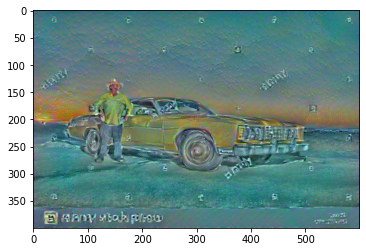

In [ ]:
plt.imshow(tensor_to_numpy(stage1_copy))

In [ ]:
stage2 = style_transfer_style_images(stage1,stage1_copy,om,7,vgg, content_tensor, style2_tensor,
                            beta=1e2, n_iterations=1000, learning_rate=0.01)


Iteration 0, Total Loss: 4401.67, Style Loss: 44.02
Iteration 50, Total Loss: 451.19, Style Loss: 4.51
Iteration 100, Total Loss: 334.83, Style Loss: 3.35
Iteration 150, Total Loss: 283.03, Style Loss: 2.83
Iteration 200, Total Loss: 247.21, Style Loss: 2.47
Iteration 250, Total Loss: 219.00, Style Loss: 2.19
Iteration 300, Total Loss: 194.76, Style Loss: 1.95
Iteration 350, Total Loss: 172.65, Style Loss: 1.73
Iteration 400, Total Loss: 151.92, Style Loss: 1.52
Iteration 450, Total Loss: 132.60, Style Loss: 1.33
Iteration 500, Total Loss: 115.13, Style Loss: 1.15
Iteration 550, Total Loss: 100.05, Style Loss: 1.00
Iteration 600, Total Loss: 87.37, Style Loss: 0.87
Iteration 650, Total Loss: 76.88, Style Loss: 0.77
Iteration 700, Total Loss: 68.24, Style Loss: 0.68
Iteration 750, Total Loss: 61.06, Style Loss: 0.61
Iteration 800, Total Loss: 55.06, Style Loss: 0.55
Iteration 850, Total Loss: 49.96, Style Loss: 0.50
Iteration 900, Total Loss: 45.54, Style Loss: 0.46
Iteration 950, Total

In [ ]:
stage2_copy = stage2.clone().detach()

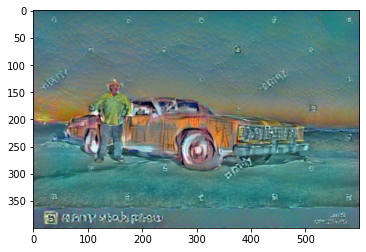

In [ ]:
plt.imshow(tensor_to_numpy(stage2_copy))

In [ ]:
stage3 = style_transfer_style_images(stage1,stage2_copy,om,15,vgg, content_tensor, style3_tensor,
                            beta=1e2, n_iterations=1000, learning_rate=0.01)

Iteration 0, Total Loss: 50685.06, Style Loss: 506.85
Iteration 50, Total Loss: 13200.94, Style Loss: 132.01
Iteration 100, Total Loss: 5421.48, Style Loss: 54.21
Iteration 150, Total Loss: 3366.81, Style Loss: 33.67
Iteration 200, Total Loss: 2350.27, Style Loss: 23.50
Iteration 250, Total Loss: 1713.83, Style Loss: 17.14
Iteration 300, Total Loss: 1299.46, Style Loss: 12.99
Iteration 350, Total Loss: 1031.64, Style Loss: 10.32
Iteration 400, Total Loss: 851.56, Style Loss: 8.52
Iteration 450, Total Loss: 723.17, Style Loss: 7.23
Iteration 500, Total Loss: 626.65, Style Loss: 6.27
Iteration 550, Total Loss: 551.10, Style Loss: 5.51
Iteration 600, Total Loss: 490.33, Style Loss: 4.90
Iteration 650, Total Loss: 440.28, Style Loss: 4.40
Iteration 700, Total Loss: 398.36, Style Loss: 3.98
Iteration 750, Total Loss: 362.87, Style Loss: 3.63
Iteration 800, Total Loss: 332.36, Style Loss: 3.32
Iteration 850, Total Loss: 305.84, Style Loss: 3.06
Iteration 900, Total Loss: 282.54, Style Loss: 

In [ ]:
stage3_copy = stage3.clone().detach()

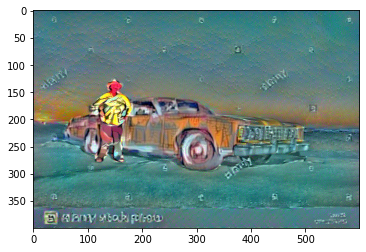

In [ ]:
plt.imshow(tensor_to_numpy(stage3_copy))

Iteration 0, Total Loss: 12376.55, Content Loss: 0.21, Style Loss: 14.54, TV Loss: 1.91


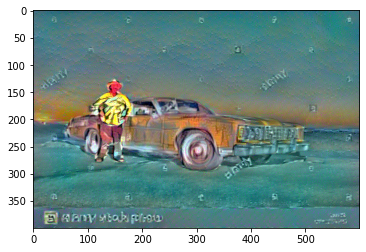

In [ ]:
stage3_copy=stage3_copy.requires_grad_(True).to("cuda")
stage4 = tv_loss_smoothing(stage3_copy,stage3_copy,om,0,vgg, content_tensor, style1_tensor,
                             alpha=1e4, beta=5e1, gamma=5e3, n_iterations=40, learning_rate=0.01)

stage4_copy = stage4.clone().detach()
plt.imshow(tensor_to_numpy(stage4_copy))



Iteration 0, Total Loss: 1491.30, TV Loss: 14.91
Iteration 50, Total Loss: 465.71, TV Loss: 4.66
Iteration 100, Total Loss: 218.17, TV Loss: 2.18
Iteration 150, Total Loss: 124.99, TV Loss: 1.25


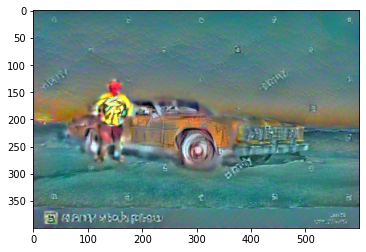

In [ ]:
stage4_copy=stage4_copy.requires_grad_(True).to("cuda")

stage5 = tv_loss_blur(stage4_copy,stage4_copy,blur_map,0,vgg, content_tensor, style3_tensor,
                             gamma=1e2, n_iterations=200, learning_rate=0.01)

stage5_copy = stage5.clone().detach()
plt.imshow(tensor_to_numpy(stage5_copy))

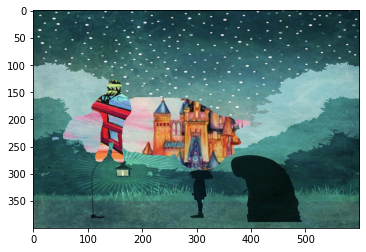

In [ ]:
# Attempt 3 - Single Shot Segmented Style Transfer

# Creates style image for SSSST 
def SS_style_tensor_creation(style1_tensor,style2_tensor,style3_tensor,fixed_om):
  style_tensor=torch.zeros((1,3,400,600))
  for i in range(400):
    for j in range(600):
      if fixed_om[i][j] == 0:
        style_tensor[0][0][i][j]=style1_tensor[0][0][i][j]
        style_tensor[0][1][i][j]=style1_tensor[0][1][i][j]
        style_tensor[0][2][i][j]=style1_tensor[0][2][i][j]
      elif fixed_om[i][j] == 7:
        style_tensor[0][0][i][j]=style2_tensor[0][0][i][j]
        style_tensor[0][1][i][j]=style2_tensor[0][1][i][j]
        style_tensor[0][2][i][j]=style2_tensor[0][2][i][j]
      elif fixed_om[i][j] == 15:
        style_tensor[0][0][i][j]=style3_tensor[0][0][i][j]
        style_tensor[0][1][i][j]=style3_tensor[0][1][i][j]
        style_tensor[0][2][i][j]=style3_tensor[0][2][i][j]
  return style_tensor

SS_style_tensor=SS_style_tensor_creation(style1_tensor,style2_tensor,style3_tensor,fixed_om).cuda()
plt.imshow(tensor_to_numpy(SS_style_tensor))

Iteration 0, Total Loss: 2187276.75, Content Loss: 0.72, Style  Loss 732.96, TV Loss: 3.99
Iteration 50, Total Loss: 757106.00, Content Loss: 0.41, Style  Loss 173.15, TV Loss: 3.08
Iteration 100, Total Loss: 399185.78, Content Loss: 0.19, Style  Loss 105.76, TV Loss: 2.79
Iteration 150, Total Loss: 256533.72, Content Loss: 0.11, Style  Loss 74.37, TV Loss: 2.67
Iteration 200, Total Loss: 174810.42, Content Loss: 0.07, Style  Loss 50.27, TV Loss: 2.61
Iteration 250, Total Loss: 125412.69, Content Loss: 0.06, Style  Loss 34.58, TV Loss: 2.56
Iteration 300, Total Loss: 98909.40, Content Loss: 0.04, Style  Loss 27.14, TV Loss: 2.50
Iteration 350, Total Loss: 83387.56, Content Loss: 0.04, Style  Loss 23.36, TV Loss: 2.43
Iteration 400, Total Loss: 72942.30, Content Loss: 0.03, Style  Loss 20.96, TV Loss: 2.37
Iteration 450, Total Loss: 65144.26, Content Loss: 0.03, Style  Loss 19.21, TV Loss: 2.32
Iteration 500, Total Loss: 59100.43, Content Loss: 0.02, Style  Loss 17.85, TV Loss: 2.27
Ite

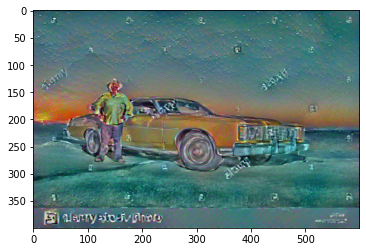

In [ ]:
# Function for preforming the SSSST

def SS_style_transfer(vgg_model,content_tensor, style_tensor,
                   alpha, beta, gamma, delta,n_iterations, learning_rate):
 
  # creating a random image and set requires_grad to True
  target_image = torch.randn_like(content_tensor).requires_grad_(True).to("cuda")
  # extract content features
  content_features = get_features(vgg_model, content_tensor)
  # extract features for style image
  style_features = get_features(vgg_model, style_tensor)

  # create optimizer to optimize the target image 
  optimizer = optim.Adam([target_image],learning_rate)
  layers_weights ={'0': 0.75,
                 '5': 0.5,
                 '10': 0.2,
                 '19': 0.2,
                 '28': 0.2}
  for i in range(n_iterations):
    optimizer.zero_grad()
    target_features=get_features(vgg_model,target_image)
    content_loss = calculate_content_loss(content_features,target_features)
    style_loss = calculate_style_loss(target_features,style_features, layers_weights) + delta * calculate_content_loss(style_features,target_features,'0')
    tv_loss = total_variation_loss(target_image)
    total_loss = alpha*content_loss+beta*style_loss+gamma*style_loss
    
    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Content Loss: {content_loss.item():.2f}, Style  Loss {style_loss.item():.2f}, TV Loss: {tv_loss.item():.2f}")
  
  return target_image


# Run the transfer function and print result

SS_output = SS_style_transfer(vgg, content_tensor, SS_style_tensor,
                              alpha=1e6, beta=1e3, gamma=1e3,delta = 20, n_iterations=1500, learning_rate=0.01)
plt.imshow(tensor_to_numpy(SS_output))